<a href="https://colab.research.google.com/github/sizday/Sarima/blob/master/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Построение модели SARIMA для временного ряда

### Data

Загрузка библиотек и необходимых данных. 

Сизов Денис - 22 столбец.

In [ ]:
import pandas as pd
import statsmodels.api as sm
import rpy2.robjects as R
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from datetime import datetime
from tqdm.notebook import tqdm
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset = pd.read_csv('/content/ts_iad21.csv', '\t', index_col=['date'], parse_dates=['date'], dayfirst=True)
row = dataset[['s22']]
row.head()

,s22
date,
2021-03-12,2
2021-03-13,1
2021-03-14,2
2021-03-15,3
2021-03-16,2


### Preprocessing

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Построим график данных в разрезе недели. На первый взгляд сезонностей и повторений не видно.

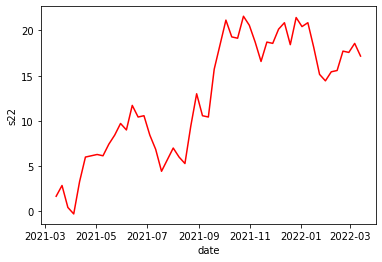

In [ ]:
otg = row.s22
week = otg.resample('w').mean()
sns.lineplot(data=week, c='r')

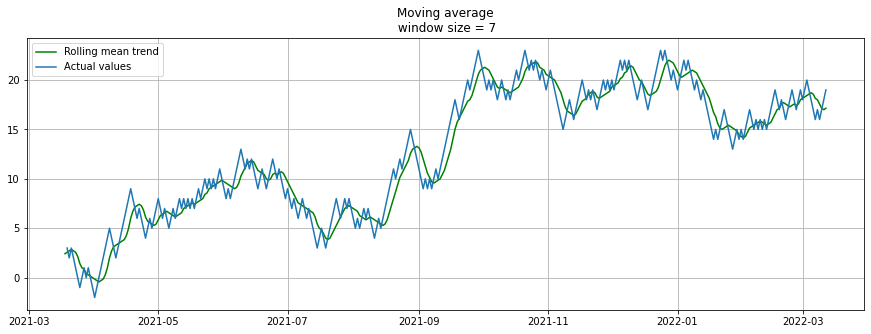

In [ ]:
plotMovingAverage(otg, 7, plot_anomalies=True)

Проверим данные на стационарность, для этого построим графики и посчитаем значения Теств Дики — Фуллера.

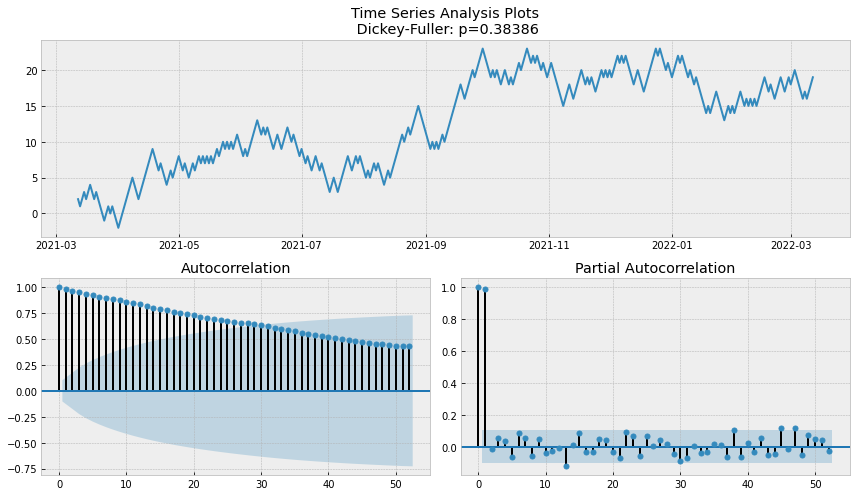

In [ ]:
tsplot(otg, lags=52)

In [ ]:
def Dickey_Fuller_test(otg):
  test = sm.tsa.adfuller(otg)
  print('adf: ', test[0])
  print('p-value: ', test[1])
  print('Critical values: ', test[4])
  if test[0] > test[4]['5%']: 
      print('есть единичные корни, ряд не стационарен')
  else:
      print('единичных корней нет, ряд стационарен')

In [ ]:
Dickey_Fuller_test(otg)

adf:  -1.7931691818963653
p-value:  0.3838582400527762
Critical values:  {'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}
есть единичные корни, ряд не стационарен


Чтобы привести ряд к стационарному виду, сместим его на 1 период.

adf:  -19.17797427396593
p-value:  0.0
Critical values:  {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}
единичных корней нет, ряд стационарен


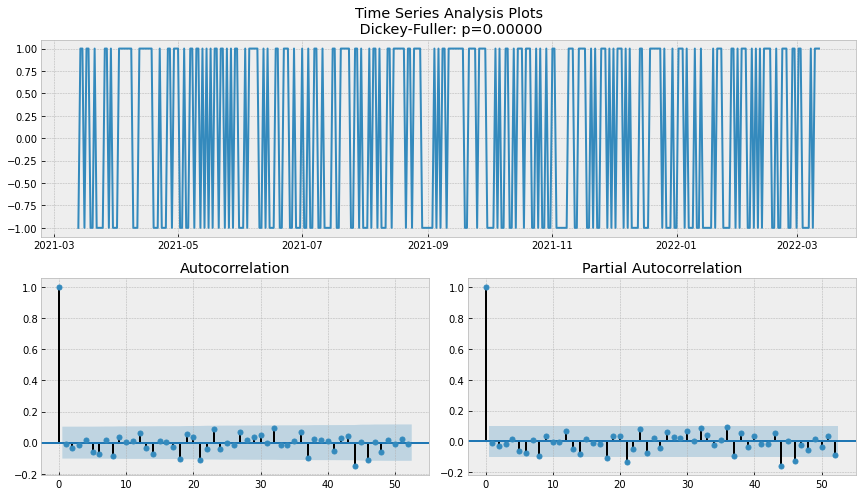

In [ ]:
otg_diff = otg.diff(periods=1).dropna()
Dickey_Fuller_test(otg_diff)
tsplot(otg_diff, lags=52)

Чтобы проверить сезонность, возьмем «сезонную разницу», что означает простое вычитание ряда из самого себя с запаздыванием, равным сезонному периоду. В нашем случае сезонность примем за 7 дней, то есть неделю

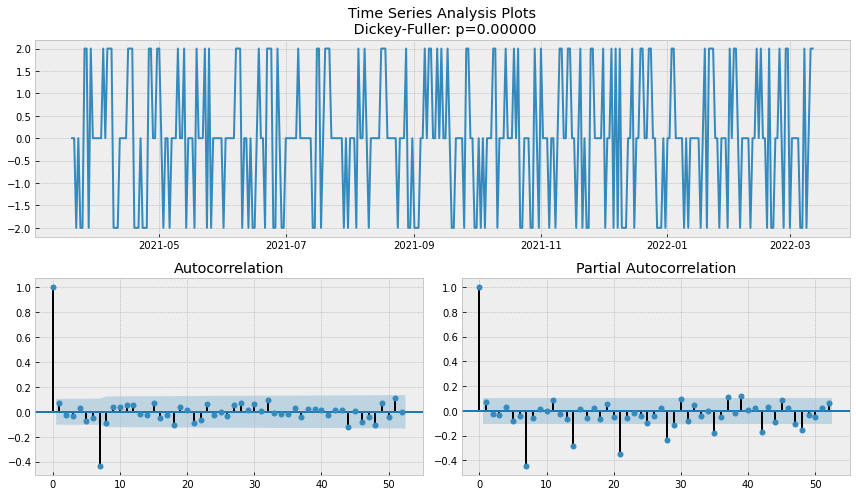

In [ ]:
otg_season = otg_diff - otg_diff.shift(7)
tsplot(otg_season[7:], lags=52)

Так как ряд стационарен, смещать не будем.

### SARIMA

Высчитаем параметры:

d = 1, так как мы приводили к стационарнуму виду

D = 0, так как после сезонности мы ничего не делали

p = 7, так как это максимальный номер на PACF сильно отличающийся от нуля

P = 6, так как из лагов кратных 7 примерно 6 отличаются

q = 1, так как только 7 на ACF выходит за границы нуля

Q = 1, так как 7 лаг сезонный

Но учитывая, что все это приблизительно добавим диапазоны значений для обучения


In [ ]:
ps = range(5, 9)
d = 1
qs = range(1, 3)
Ps = range(6, 8)
D = 0
Qs = range(0, 2)
s = 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

32

In [ ]:
def optimizeSARIMA(data, parameters_list, d, D, s):

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                data,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(row.s22, parameters_list, d, D, s)

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 15min 58s, sys: 11min 9s, total: 27min 7s
Wall time: 14min 55s


In [ ]:
result_table.head(10)

,parameters,aic
0,"(8, 2, 7, 0)",1049.662803
1,"(7, 2, 7, 0)",1050.175178
2,"(5, 2, 6, 0)",1050.711882
3,"(5, 1, 6, 0)",1051.300860
4,"(8, 1, 6, 0)",1052.342309
5,"(7, 1, 6, 0)",1052.417508
6,"(5, 2, 7, 0)",1052.471185
7,"(7, 1, 7, 0)",1052.613347
8,"(5, 2, 6, 1)",1052.709059
9,"(5, 2, 7, 1)",1052.772944


In [ ]:
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(row.s22, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                               s22   No. Observations:                  366
Model:             SARIMAX(8, 1, 2)x(7, 0, 0, 7)   Log Likelihood                -506.831
Date:                           Thu, 24 Mar 2022   AIC                           1049.663
Time:                                   20:36:22   BIC                           1119.861
Sample:                               03-12-2021   HQIC                          1077.560
                                    - 03-12-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4353      0.057    -25.173      0.000      -1.547      -1.324
ar.L2         -0.9824      0.094    -10.506

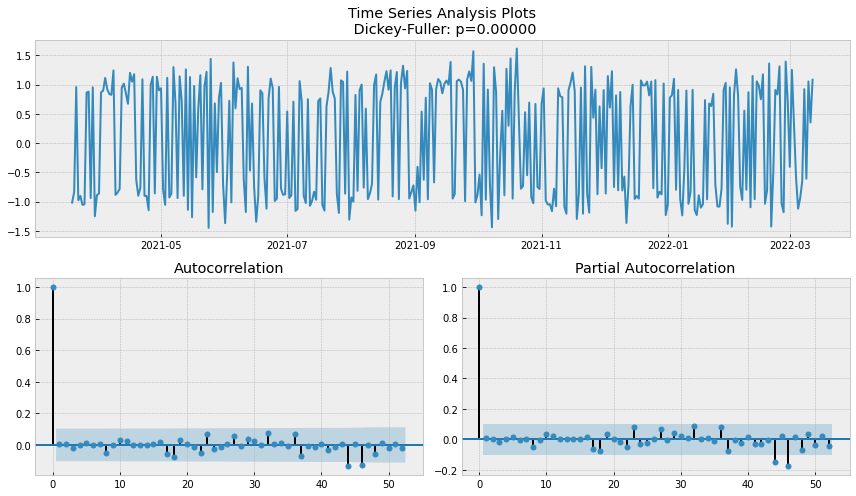

In [ ]:
tsplot(best_model.resid[7:], lags=52)

Итого: получилось построить модель SARIMA, идеальными параметрами оказались SARIMAX(8, 1, 2)x(7, 0, 0, 7)